In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import ERFutils
import dask
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import cf_xarray as cfxr
import scipy.signal as signal
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve_triangular

import seaborn as sns
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [9]:
experiments = ['1pctCO2','piControl','historical','ssp126','ssp245','ssp370','ssp585']
models = {'EC-Earth3-Veg':'EC-Earth3-Veg',
         'EC-Earth3-Veg-LR':'EC-Earth3-Veg-LR'}

variables = ['tas','rsdt','rsut','rlut']

check_imported(experiments, models, variables, False)

Experiment: 1pctCO2
	Model: EC-Earth3-Veg
		Missing: ['tas', 'rsdt', 'rsut', 'rlut']
	Model: EC-Earth3-Veg-LR
		All variables present!
Experiment: piControl
	Model: EC-Earth3-Veg
		Missing: ['tas', 'rsdt', 'rsut', 'rlut']
	Model: EC-Earth3-Veg-LR
		Missing: ['tas', 'rsdt', 'rsut']
Experiment: historical
	Model: EC-Earth3-Veg
		Missing: ['tas', 'rsdt', 'rsut', 'rlut']
	Model: EC-Earth3-Veg-LR
		Missing: ['tas', 'rsdt', 'rsut', 'rlut']
Experiment: ssp126
	Model: EC-Earth3-Veg
		Missing: ['tas', 'rsdt', 'rsut', 'rlut']
	Model: EC-Earth3-Veg-LR
		Missing: ['tas', 'rsdt', 'rsut', 'rlut']
Experiment: ssp245
	Model: EC-Earth3-Veg
		Missing: ['tas', 'rsdt', 'rsut', 'rlut']
	Model: EC-Earth3-Veg-LR
		Missing: ['tas', 'rsdt', 'rsut', 'rlut']
Experiment: ssp370
	Model: EC-Earth3-Veg
		Missing: ['tas', 'rsdt', 'rsut', 'rlut']
	Model: EC-Earth3-Veg-LR
		Missing: ['tas', 'rsdt', 'rsut', 'rlut']
Experiment: ssp585
	Model: EC-Earth3-Veg
		Missing: ['tas', 'rsdt', 'rsut', 'rlut']
	Model: EC-Earth3-Veg-

In [5]:
def check_imported(experiments,models,variables,print_path=False):
    path_to_cmip6_data_local = '../cmip6_data/'
    path_to_cmip6_data = path_to_cmip6_data_local
    
    failed = {}
    
    for exp_id in experiments:
        print(f'Experiment: {exp_id}') 
        failed[exp_id] = {}
        for m in models:
            print(f'\tModel: {m}')
            failed[exp_id][m] = []
            for var in variables:
                try:
                    if print_path:
                        print(f'{path_to_cmip6_data}{exp_id}/{var}_Amon_{models[m]}_{exp_id}_r1i1p1f1**')
                    xr.open_mfdataset(f'{path_to_cmip6_data}{exp_id}/{var}_Amon_{models[m]}_{exp_id}_r1i1p1f1**', use_cftime=True)
                except:
                    failed[exp_id][m].append(var)
                    
            if len(failed[exp_id][m]) == 0:
                print('\t\tAll variables present!')
            else:
                print(f'\t\tMissing: {[m_var for m_var in failed[exp_id][m]]}')
                
    return
    

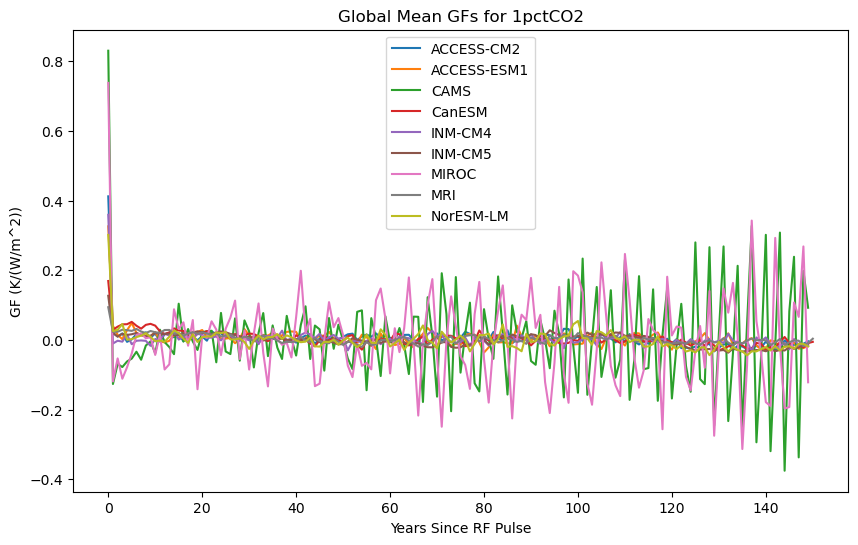

In [12]:
train_id = '1pctCO2'
G_master_ds = xr.open_dataset(f'../Outputs/RF_Outputs/G_{train_id}_F_all_ds.nc4')
RFutils.plot_mean_Greens(G_master_ds, train_id, overlay = True, save_fig = False)